In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
#plotly.tools.set_credentials_file(username='', api_key='')


In [2]:
geo_data = pd.read_json('1940_singh_census_with_geodata.json')
geo_data.columns

Index(['age', 'birthPlace', 'birthPlaceGeocodedData', 'birthPlaceNormalized',
       'birthYearApprox', 'censusLocation', 'censusLocationGeocodedData',
       'censusLocationNormalized', 'children', 'gender', 'identifier',
       'inferredGroups', 'maritalStatus', 'name', 'parents', 'raceRecorded',
       'raceRecordedNormalized', 'relationshipToHead', 'siblings', 'spouse'],
      dtype='object')

In [3]:
len(geo_data.index)

962

In [4]:
geo_data['censusLocationGeocodedData'][0]

{'address': {'country': 'United States of America',
  'country_code': 'us',
  'county': 'Maricopa County',
  'state': 'Arizona'},
 'boundingbox': ['32.5049739', '34.04739', '-113.333755', '-111.0399049'],
 'class': 'boundary',
 'display_name': 'Maricopa County, Arizona, United States of America',
 'icon': 'http://nominatim.openstreetmap.org/images/mapicons/poi_boundary_administrative.p.20.png',
 'importance': '0.94083416919723',
 'lat': '33.34883',
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://www.openstreetmap.org/copyright',
 'lon': '-112.49123',
 'osm_id': '1832201',
 'osm_type': 'relation',
 'type': 'administrative'}

In [5]:
type(geo_data['censusLocationGeocodedData'][0])

dict

In [6]:
coords = [{'lat': data['lat'], 'lon': data['lon'], 'name': data['display_name'], 'county': data['address']['county']} for data in geo_data['censusLocationGeocodedData']]
coords_df = pd.DataFrame(coords)

In [7]:
coords_df.head()

,county,lat,lon,name
0,Maricopa County,33.34883,-112.49123,"Maricopa County, Arizona, United States of Ame..."
1,Maricopa County,33.34883,-112.49123,"Maricopa County, Arizona, United States of Ame..."
2,Maricopa County,33.34883,-112.49123,"Maricopa County, Arizona, United States of Ame..."
3,Maricopa County,33.34883,-112.49123,"Maricopa County, Arizona, United States of Ame..."
4,Maricopa County,33.34883,-112.49123,"Maricopa County, Arizona, United States of Ame..."


In [8]:
fips_mapping = pd.read_csv('fips.csv')
fips_mapping.head()

,state,state_code,county_code,county,fips_class_code
0,AL,1,1,Autauga County,H1
1,AL,1,3,Baldwin County,H1
2,AL,1,5,Barbour County,H1
3,AL,1,7,Bibb County,H1
4,AL,1,9,Blount County,H1


In [9]:
for i in coords_df.county:
    if i not in fips_mapping['county'].values:
        print(i)

Doña Ana County
Doña Ana County
Doña Ana County
Doña Ana County
Doña Ana County
Manhattan
Manhattan
Manhattan
New York


In [10]:
modern_county_mapping = {'New York': 'New York County', 'Manhattan': 
                         'New York County', 'Doña Ana County': 'Dona Ana County'}
replace_county = lambda name: modern_county_mapping[name] if name in modern_county_mapping else name

In [11]:
coords_df['county'] = [replace_county(i) for i in coords_df['county']]

In [101]:
coords_df.merge(fips_mapping, on='county', how='left').shape

(1342, 9)

There were 962 rows in the original dataframe, so we should look at joining by county and state name.

In [13]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

In [14]:
state_code = [us_state_abbrev[data['address']['state']] for data in geo_data['censusLocationGeocodedData']]
coords_df['state'] = state_code

In [15]:
coords_fips = coords_df.merge(fips_mapping, on=['state', 'county'], how='left')
coords_fips.columns

Index(['county', 'lat', 'lon', 'name', 'state', 'state_code', 'county_code',
       'fips_class_code'],
      dtype='object')

In [16]:
state_codes = coords_fips['state_code'].astype(str)
county_codes = coords_fips['county_code'].astype(str)
def combine_codes(state, county):
    code_lst = []
    for i in np.arange(len(state.index)):
        complete_code = ''
        if len(state[i]) == 1:
            state[i] = '0' + state[i]
        complete_code += state[i]
        if len(county[i]) != 3:
            county[i] = ('0' * (3 - len(county[i]))) + county[i]
        complete_code += county[i]
        code_lst.append(complete_code)
    return code_lst

In [17]:
from collections import Counter
complete_fips = combine_codes(state_codes, county_codes)
people_per_county = Counter(complete_fips)
fips_codes = list(people_per_county.keys())
counts = list(people_per_county.values())
fig = ff.create_choropleth(fips=fips_codes, values=counts)
py.iplot(fig)

In [18]:
ca_data = coords_fips[coords_fips['state'] == 'CA']
ca_codes = combine_codes(pd.Series(ca_data['state_code'].astype(str).values, index=np.arange(len(ca_data.index))),
              pd.Series(ca_data['county_code'].astype(str).values, index=np.arange(len(ca_data.index))))
ca_per_county = Counter(ca_codes)
fips_ca = list(ca_per_county.keys())
counts_ca = list(ca_per_county.values())
ca_fig = ff.create_choropleth(
    fips=fips_ca, values=counts_ca, scope=['California'],
    round_legend_values=True,
    simplify_county=0, simplify_state=0,
    county_outline={'color': 'rgb(15, 15, 55)', 'width': 0.5},
    state_outline={'width': 1},
    legend_title='pop. per county',
    title='Population of People with Surname "Singh" in California (1940)')
py.iplot(ca_fig)

## Clustering

First, we will look at the data at a glance, to see if we can find patterns by inspection. This will not be on a map, but rather on a coordinate plane.

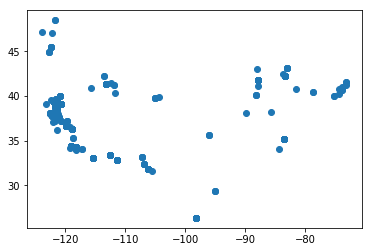

In [103]:
features = ['lat', 'lon']
ll_data = coords_df[features]
ll_data['lat'] = ll_data['lat'].astype('float')
ll_data['lon'] = ll_data['lon'].astype('float')
plt.scatter(data['lon'], data['lat'])

Because the data are already at the scale we want them, and because we want to visualize the clusters on the map, we will run the k-means algorithm for clustering. As $k$ is the number of clusters, we will use the "elbow method" to find the optimal value for $k$, by minimizing the function which relates the sum of the squared errors to the number of clusters. 

In [104]:
from sklearn import cluster

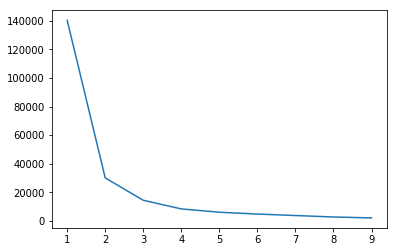

In [106]:
k_counts = np.arange(1, 10)
sse = []
for k in k_counts:
    model = cluster.KMeans(n_clusters = k)
    model = model.fit(ll_data)
    sse.append(model.inertia_)
plt.plot(k_counts, sse)

The point of inflection in the curve appears to be somewhere between 2, 3, and 4. Let's first visualize the points on a coordinate grid, and then on a map.

In [107]:
def plot_clusters(k, data):
    model = cluster.KMeans(n_clusters = k)
    model = model.fit(data)
    plt.scatter(data['lon'], data['lat'], c=model.labels_.astype(float))
    print(Counter(model.labels_))
    return model.labels_

Counter({0: 865, 1: 97})


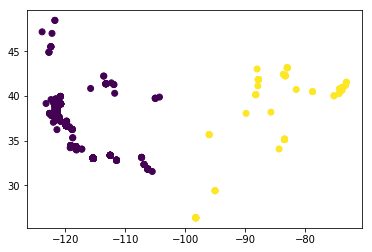

In [108]:
two_clusters = plot_clusters(2, ll_data)

Counter({0: 522, 2: 353, 1: 87})


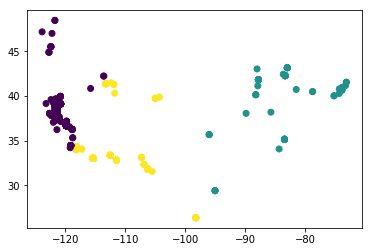

In [109]:
three_clusters = plot_clusters(3, ll_data)

Counter({3: 508, 0: 321, 1: 81, 2: 52})


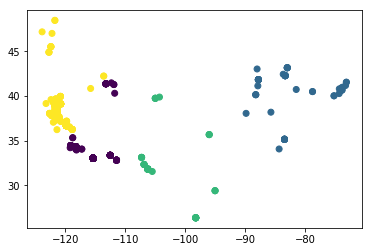

In [110]:
four_clusters = plot_clusters(4, ll_data)

In [112]:
def add_cluster_col(name, labels, data):
    data[name] = labels

In [113]:
args = [('clusters_2', two_clusters), ('clusters_3', three_clusters), ('clusters_4', four_clusters)]
for t in args:
    add_cluster_col(t[0], t[1], ll_data)

In [114]:
ll_data.head()

,lat,lon,clusters_2,clusters_3,clusters_4
0,33.34883,-112.49123,0,2,0
1,33.34883,-112.49123,0,2,0
2,33.34883,-112.49123,0,2,0
3,33.34883,-112.49123,0,2,0
4,33.34883,-112.49123,0,2,0


In [115]:
def map_clusters(k, data):
    map_data = [dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = data['lon'],
        lat = data['lat'],
        mode = 'markers',
        marker = dict(
            size = 5,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'circle',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            color = data['clusters_' + str(k)],

        ))]

    layout = dict(
            title = 'Assigned Clusters (k = ' + str(k) + ')',
            geo = dict(
                scope='usa',
                projection=dict( type='albers usa' ),
                showland = True,
                landcolor = "rgb(250, 250, 250)",
                subunitcolor = "rgb(217, 217, 217)",
                countrycolor = "rgb(217, 217, 217)",
                countrywidth = 0.5,
                subunitwidth = 0.5
            ),
        )

    fig = dict(data=map_data, layout=layout)
    return fig

If $k=2$, we see a division between the eastern and western US

In [116]:
py.iplot(map_clusters(2, ll_data))

If $k = 3$, we see a distinction between Eastern US, Southwestern US, Western US

In [117]:
py.iplot(map_clusters(3, ll_data))

If $k = 4$, clusters are roughly in Northern CA/Pacific NW, Southern CA, AZ, UT, Midwestern US, Eastern US

In [119]:
py.iplot(map_clusters(4, ll_data))

1. Use other features(age, immigration status, birthplace coords) as part of clustering
2. Density-based approach